In [1]:
from ipyleaflet import Map, Marker, basemaps, Popup, Circle
from ipywidgets import HTML
import csv, pandas as pd, numpy as np, matplotlib.pyplot as plt, re, math, pgeocode
from collections import defaultdict

def clamp(n, minimum, maximum):
    return max(min(maximum, n), minimum)

In [2]:
def func(m, x, b):
    return m*x + b

In [3]:
def draw_circle():
     if building[place]['Floor Area'] > 10:
        circle = Circle()
        circle.location = (building[place]['Latitude'], building[place]['Longitude'])
        max_eff = 1500
        circle.radius = rad

        #Calculates the color based on ghg/energy, higher means more red
        green = str(hex(int(clamp(1 - eff/(max_eff), 0, 0.5) * 255 * 2)))
        if int(green, 16) < 16:
            green = "0" + green
        green = green.replace("0x", "")

        red = str(hex(int(clamp(eff/(max_eff), 0, 0.5) * 255 * 2)))
        if int(red,16) < 16:
            red = "0" + red
        red = red.replace("0x", "")

        col = "#" + red + green + "00"
        circle.color = col
        circle.fill_color = col

        #Creates a popup for each circle
        popup2 = Popup(
            location=(building[place]['Latitude'], building[place]['Longitude']),
            close_button=False,
            auto_close=False,
            close_on_escape_key=False
        )

        #Creates message, which shows division and percentage
        message2 = HTML()
        nrg = building[place]['Energy']
        message2.value = (f'\t{place}, {nrg} kWh, {eff}')

        m.add_layer(circle)
        circle.popup = message2

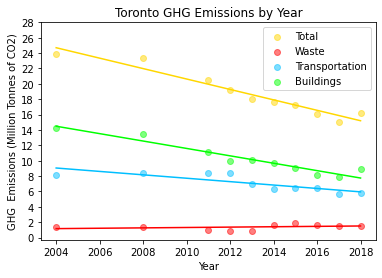

In [4]:
#This cell graphs CO2 emissions, population and year

data = []
total = []
waste = []
transport = []
building = []
color = ["Gold", "Red", "DeepSkyBlue", "Lime"]
year = []

with open('data/1990-2018 GHG Emissions.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    
    #Stores data in arrays
    for line in csv_reader:
        data.append(line)
        total.append(float(line['Total']))
        waste.append(float(line['Waste']))
        transport.append(float(line['Transportation']))
        building.append(float(line['Buildings']))
        year.append(int(line["Year"]))
                
data = ([total], [waste], [transport], [building], [year])

#Creates Legend and Plots graph
plt.scatter(year, total, c="Gold", alpha=0.5, label="Total")
plt.scatter(year, waste, c="Red", alpha=0.5, label="Waste")
plt.scatter(year, transport, c="DeepSkyBlue", alpha=0.5, label="Transportation")
plt.scatter(year, building, c="Lime", alpha=0.5, label="Buildings")

#Line of best fit
for i in range(len(data) - 1):
    x = np.array(data[4]).flatten() 
    y = np.array(data[i]).flatten()
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, func(m,x,b), color=color[i])

#Draws Graph
plt.title('Toronto GHG Emissions by Year')
plt.xlabel('Year')
plt.ylabel('GHG  Emissions (Million Tonnes of CO2)')
plt.legend()
plt.xticks(np.arange(2004, 2019, 2))
plt.yticks(np.arange(0, 30, 2))
plt.show()

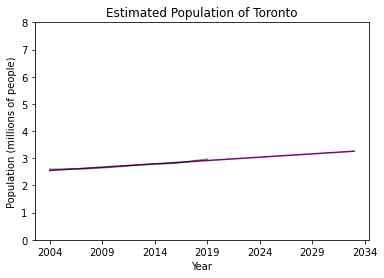

In [5]:
#This cell graphs population vs time
#Source: www.macrotrends.net, from UN world population aspects

pop = []
year2 = []
trend = []
l = []

with open('data/Population.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    
    #Stores data in arrays
    for line in csv_reader:
        date = int(line['label'])
        if date >= 2004:
            year2.insert(0, date)
            pop.insert(0, float(line['Total Population'])/1000000)
            
#Line of best fit
x = np.array(year2)
y = np.array(pop)
m, b = np.polyfit(x, y, 1)
for i in range(30):
    trend.append(func(m,(2004 + i),b))
    l.append(2004 + i)
plt.plot(l, trend, "Purple")
    
#Draws graph
plt.plot(year2, pop, c="Black", alpha=0.5)
plt.title('Estimated Population of Toronto')
plt.xlabel('Year')
plt.ylabel('Population (millions of people)')
plt.xticks(np.arange(2004, 2037, 5))
plt.yticks(np.arange(0, 9, 1))
plt.show()

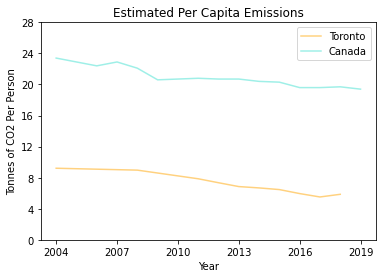

In [6]:
emissions = []
per_capita = []
year3 = []
can_pc = []

with open('data/Canada Per Capita Emissions.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    
    for line in csv_reader:
        can_pc.append(float(line['Emissions']))
        year3.append(float(line['Year']))
        
#Calculating estimated per capita emissions using UN data and trend line
x = np.array(data[4]).flatten() 
y = np.array(data[0]).flatten()
m, b = np.polyfit(x, y, 1)

#This is for extrapolating
for i in range(len(year)):
    y = func(m , (i + 2004), b)
    #per_capita.append(float(y)/pop[i])
    per_capita.append(float(total[i]/pop[i]))
    
#Creates Legend and Plots graph
plt.plot(year, per_capita, c="Orange", alpha=0.5, label="Toronto")
plt.plot(year3, can_pc, c="Turquoise", alpha=0.5, label="Canada")

#Draws graph
plt.title('Estimated Per Capita Emissions')
plt.xlabel('Year')
plt.ylabel('Tonnes of CO2 Per Person')
plt.yticks(np.arange(0, 30, 4))
plt.xticks(np.arange(2004, 2021, 3))
plt.legend()
plt.show()


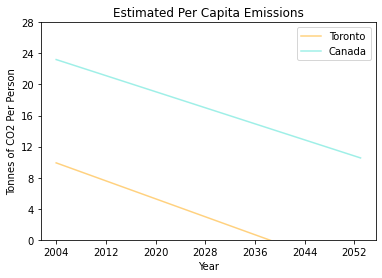

In [7]:
#Line of best fit
x = np.array(year)
y = np.array(per_capita)
m, b = np.polyfit(x, y, 1)

q = np.array(year3)
p = np.array(can_pc)
s, t = np.polyfit(q, p, 1)

year.clear()
per_capita.clear()
year3.clear()
can_pc.clear()

for i in range(50):
    per_capita.append(func(m, i + 2003 , b))
    can_pc.append(func(s, i + 2003, t))
    year.append(2004 + i)
    year3.append(2004 + i)

#Creates Legend and Plots graph
plt.plot(year, per_capita, c="Orange", alpha=0.5, label="Toronto")
plt.plot(year3, can_pc, c="Turquoise", alpha=0.5, label="Canada")

#Draws graph
plt.title('Estimated Per Capita Emissions')
plt.xlabel('Year')
plt.ylabel('Tonnes of CO2 Per Person')
plt.yticks(np.arange(0, 30, 4))
plt.xticks(np.arange(2004, 2056, 8))
plt.legend()
plt.ylim(0, None)
plt.show()
    

<h1>Graph Analysis</h1>
    <p>The first graph clearly indicates that Toronto has made significant progress in cutting down their greenhouse gas emissions since 2004 (emissions have been decreasing before 2004, we just didn’t have enough data to graph). It appears the city is well on track to meet it’s carbon neutral goal by 2050. It is worth noting that emissions from buildings are decreasing the fastest while emissions from waste haven’t decreased since 2004. The reasons for increased progress in the areas of buildings could be due to a combination of factors, such as the fact that buildings make up for the majority of emissions, the use of green roofs to reduce energy consumption and the use of renewables. </p>
    
   <p>The reason progress is slower for transportation and waste is likely largely attributed to the fact that these are more heavily influenced by population. While a building needs heating whether there is 1 person or there are 10, more people means more cars and more waste. Encouraging the use of public transport can help cut down transport emissions while reducing the amount of waste generated by the city can reduce waste emissions. It is easy to underlook the significance of waste emissions as they only make up a fraction of the total emissions, but should the trend continue, total emissions will decrease to the point where waste makes up a significant part of it. </p>
   
   <p>Although the population has been rising since 2004, per capita emissions have significantly decreased. Toronto is quite ahead of the national average when it comes to per capita emissions. We all live on the same planet, so this goes to show that as important as it is for Toronto to reduce emissions, it is also important for Toronto to share it's success strategies with the rest of the world. </p>
   
   <p>From this graph, Toronto's goal of being carbon neutral by 2050 is realistic and the city on track. While according to the graph Toronto will be carbon neutral by around 2038, realistically the trend wouldn't be linear due to the fact that the more you cut emissions, the less emissions there are to reduce, similarly to how a 100 kg can lose weight more easily than a 60 kg person. Still, the graph looks very convincing. With initiative, the city could drastically exceed it's 2050 goal and become carbon neutral much earlier. We will now look into how Toronto can reduce building emissions, the largest category. </p>

In [8]:
#This cell organizes the data for renewable installations

renewable = {}
with open('data/Renewable Energy Installations.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)

    for line in csv_reader:
        name = line['LINEAR_NAME_FULL']
        geo = line['geometry']
        
        renewable.setdefault(name, {
            'Latitude': 0,
            'Longitude': 0
        })
        
        #Gathers coordinates of renewables
        x = re.search(r"\(([A-Za-z0-9.\-,\s]+)\)", geo)
        coordinates = x.group(1).split(", ")
        
        renewable[name]['Latitude'] = coordinates[1]
        renewable[name]['Longitude'] = coordinates[0]

for i, value in renewable.items():
    #print(i)
    a = renewable[i]['Latitude']
    b = renewable[i]['Longitude']
    #print(f'\t{a}, {b}')

In [9]:
#This cell organizes the data for CO2 emissions

building = {}

with open('data/Annual Energy.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    
    for line in csv_reader:
        #print(line)
        name = line['\ufeffOperation Name']
        if not name == "":
            if (not line['Total (calculated in webform)'].replace(",","") == ""):
                emissions = float(line['Total (calculated in webform)'].replace(",",""))
            else:
                emissions = 0
            postal = line['Postal Code']
            nomi = pgeocode.Nominatim('ca')
            
            energy = float(line['Energy Type and Amount Purchased and Consumed in Natural Units'].replace(",", ""))
            area = max(float(line['Total Floor Area'].replace(",", "")), 1)
        
            building.setdefault(name, {
                'Emissions': 0,
                'Latitude': 0,
                'Longitude': 0,
                'Energy': 0,
                'Floor Area': 0,
                'Efficiency': 0
            })
        
            nomi = nomi.query_postal_code(postal)
            #Sets Coordinates
            building[name]['Longitude'] = (nomi.longitude)
            building[name]['Latitude'] = (nomi.latitude)
            building[name]['Emissions'] = emissions
            building[name]['Energy'] = energy
            building[name]['Floor Area'] = area
            building[name]['Efficiency'] = energy/area

for place, value in building.items():
    a = building[place]['Longitude']
    b = building[place]['Latitude']
    c = building[place]['Emissions']
    d = building[place]['Energy']

    #e = float(c)/float(d)
    #print(place)
    #print(f'\t Coordinates:{a}, {b} - Emissions:{c} - Energy:{d} = {e}')

#Makes a table displaying information
df = pd.DataFrame(building).T

df

,Emissions,Latitude,Longitude,Energy,Floor Area,Efficiency
Stephenson Building,0.0,43.6641,-79.3889,2.181065e+06,135034.0,16.151969
2 Civic Centre Court,115197.0,43.6437,-79.5767,1.259537e+06,46145.0,27.295192
51 Lisgar,12565.0,43.6480,-79.4177,7.094746e+04,10053.0,7.057343
Archives and Records Centre,108376.0,43.6736,-79.4035,4.801582e+05,39590.0,12.128270
Atlantic Ave Storage Bldg,55473.0,43.6383,-79.4301,1.056177e+05,43002.0,2.456112
...,...,...,...,...,...,...
West Toronto Pumping Station,178196.0,43.6748,-79.4839,4.454903e+06,7739.0,575.643233
F.J. Horgan Filtration Plant,2062673.0,43.7678,-79.1866,3.965985e+07,325447.0,121.862713
Island Filtration Plant,367898.0,43.6230,-79.3936,7.770374e+06,64196.0,121.041409
R.C. Harris Filtration Plant,1918036.0,43.6784,-79.2941,4.589065e+07,115368.0,397.776289


In [10]:
#This cell organizes data for green roofs

roof = {}

with open ('data/Green Roofs.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    
    for line in csv_reader:
        complete = line["COMPLETED_DATE"]
        postal = line["POSTAL"]
        if not complete == "" and not postal == "   ":
            street = line["STREET_NAME"]
            area = float(line['GREEN_ROOF_AREA'].replace(",", ""))
            
            roof.setdefault(street, {
                'Area': 0,
                'Latitude': 0,
                'Longitude': 0
            })
            
            nomi = pgeocode.Nominatim('ca')
            nomi = nomi.query_postal_code(postal)
            roof[street]['Longitude'] = (nomi.longitude)
            roof[street]['Latitude'] = (nomi.latitude)
            roof[street]['Area'] = area

roof = dict(sorted(roof.items(), key = lambda kv: kv[1]['Area'], reverse=True))
max_area = roof[next(iter(roof))]['Area'] 


In [11]:
#This cell maps green roof locations vs energy use

m = Map(center = (43.6487, -79.38544), zoom = 10, min_zoom = 1, max_zoom = 20, 
    basemap=basemaps.Stamen.Terrain)
#Sorts dictionary by highest to lowest emissions so on the map the big circle appears below
building = dict(sorted(building.items(), key = lambda kv: kv[1]['Energy'], reverse=True))

# Adds circle markers for green roofs
for street, value in roof.items():
    area = roof[street]['Area']
    if area > 0:
        circle = Circle()
        circle.location = (roof[street]['Latitude'], roof[street]['Longitude'])
        circle.radius = int(clamp(1000 * area/2000, 100, 1000))
        #Calculates the color based on greenhouse gas emissions, higher means more red

        col = "Green"
        circle.color = col
        circle.fill_color = col
    
        #Creates a popup for each circle
        popup2 = Popup(
            location=(roof[street]['Latitude'], roof[street]['Longitude']),
            close_button=False,
            auto_close=False,
            close_on_escape_key=False
        )
    
        #Creates message, which shows division and percentage
        message = HTML()
        message.value = (f'\t{street}, {area} m^2')
    
        m.add_layer(circle)
        circle.popup = message
#Adds circle markers for energy consumption
for place, value in building.items():
    area = building[place]['Floor Area']
    if area > 100:
        circle = Circle()
        circle.location = (building[place]['Latitude'], building[place]['Longitude'])
        eff = building[place]['Efficiency']
        max_rad = 1000
        rad = int(clamp(math.pow(eff * 100, 1.0/2), 50, 1000))
        circle.radius = rad

        #Calculates the color based on ghg/energy, higher means more red
        green = str(hex(int(clamp((max_rad - rad)/(max_rad), 0, 0.5) * 255 * 2)))
        if int(green, 16) < 16:
            green = "0" + green
        green = green.replace("0x", "")

        red = str(hex(int(clamp(rad/(max_rad), 0, 0.5) * 255 * 2)))
        if int(red,16) < 16:
            red = "0" + red
        red = red.replace("0x", "")

        col = "#" + red + green + "00"
        circle.color = col
        circle.fill_color = col

        #Creates a popup for each circle
        popup2 = Popup(
            location=(building[place]['Latitude'], building[place]['Longitude']),
            close_button=False,
            auto_close=False,
            close_on_escape_key=False
        )

        #Creates message, which shows division and percentage
        message2 = HTML()
        nrg = building[place]['Energy']
        message2.value = (f'\t{place}, {nrg} kWh, Efficiency: {eff}, Area: {area} m^2')

        m.add_layer(circle)
        circle.popup = message2
m

Map(center=[43.6487, -79.38544], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

<h1> Green Roof Analysis </h1>

<p> Disclaimer: Pgeocode only takes the first 3 characters of a postal code. As a result, locations on the same street will appear to be on the same area so it is impossible to tell if a greenroof corresponds to the same building as the one used for energy usage. There is also a minimum and maximum radius of map circles, don't compare data points on circle size. Energy comparisons aren't entirely fair. It doesn't take what the building does into account, so </p>


<p> Understanding the Map: The dark green circles indicate locations with green roofs. The size of these circles indicates the surface of these green roofs, in square meters. Datapoints for energy consumption can range from red in color to green. For energy usage, the data represented is calculated by the energy consumed in kWh divided by the square footage of the building. Large red circles indicate high energy concentration, while small green circles indicate the opposite. Again, there is a cap to the size of these circles, so clicking on them to get the actual value is importart for making comparisons. </p>

<p> The idea for this data comparison is that green roofs are thought to save air conditioning energy by a significant percent. We are looking to see how effective green roofs at saving energy. </p>

<p> The fact Pgeocode only uses the first 3 characters of the postal code is inconvienient for this comparison, but a general pattern can still be observed. For example, only one of the large green circles representing green roof area contained a circle colored yellow-red. Even still, the yellow circle might not correspond to the greenroof. While many yellow+ rated circles have green roofs, these green roofs may not be on the same building and are relatively small. Additionally, green roofs save energy by helping a building regulate temperature without air conditioning, so building with high energy usage due to other factors such as the treatment plants will still have high energy consumption regardless of green roofs. Overall, green roofs seem like a promising strategy to help the city save energy and should continue to be used and promoted. Some ways to maximize the effects of green roofs would be designing buildings to accomodate larger green roofs. For example, a sloped roof has more area than a flat roof and some buildings have roof designs that cannot accomodate green roofs, such as the pointed top of the empire state building. </p>

In [12]:
#This cell maps renewables vs GHG emissions

highEmission = 3000000
#Sorts dictionary by highest to lowest emissions so on the map the big circle appears below
building = dict(sorted(building.items(), key = lambda kv: kv[1]['Emissions'], reverse=True))

#Creates map
m = Map(center = (43.6487, -79.38544), zoom = 10, min_zoom = 1, max_zoom = 20, 
    basemap=basemaps.Stamen.Terrain)
#m = Map(center = (43.6656, -79.383), zoom = 10, min_zoom = 1, max_zoom = 20)

#Adds markers
#https://ipyleaflet.readthedocs.io/en/latest/api_reference/popup.html
for i, value in renewable.items():
    #Stores coordinates in integers
    a = renewable[i]['Latitude']
    b = renewable[i]['Longitude']
    
    #Adds all the markers
    center = (a, b)
    marker = Marker(location=center, draggable=False)
    m.add_layer(marker);
    
    #Creates message
    message = HTML()
    message.value = i
    
    #Creates popup
    popup = Popup(
        location=center,
        close_button=False,
        auto_close=False,
        close_on_escape_key=False
    )
    #Adds popup to layer and associates it with the message and marker
    marker.popup = message
    
# Adds circle markers
for place, value in building.items():
    circle = Circle()
    circle.location = (building[place]['Latitude'], building[place]['Longitude'])
    ghg = building[place]['Emissions']
    circle.radius = int(clamp(math.sqrt(ghg), 50, 1750))
    #Calculates the color based on greenhouse gas emissions, higher means more red
    green = str(hex(int(clamp(highEmission - ghg, 0, highEmission/2) * 2 * 255/highEmission)))
    if int(green, 16) < 16:
        green = "0" + green
    green = green.replace("0x", "")
    
    red = str(hex(int(clamp(ghg, 0, highEmission/2) * 2 * 255/highEmission)))
    if int(red,16) < 16:
        red = "0" + red
    red = red.replace("0x", "")
    
    col = "#" + red + green + "00"
    circle.color = col
    circle.fill_color = col
    
    #Creates a popup for each circle
    popup2 = Popup(
        location=(building[place]['Latitude'], building[place]['Longitude']),
        close_button=False,
        auto_close=False,
        close_on_escape_key=False
    )
    
    #Creates message, which shows division and percentage
    message2 = HTML()
    name = place
    message2.value = (f'\t{name}, {ghg} kg')
    
    m.add_layer(circle)
    circle.popup = message2

#Draws Map
m

Map(center=[43.6487, -79.38544], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

<h1>Renewables Analysis</h1>
    <p> Disclaimer: Renewable installations data doesn't take into account how much power is generated from it. </p>
    
   <p> This data tells us that the biggest contributors to green house gas emissions in Toronto are treatment plants and public transport stations, with Main Treatment Plant taking the cake at over 18 million kilograms of carbon dioxide. Many of these large red circles do not have renewables nearby, although it is important to recognize that the data may be missing. The pointers use coordinates, while the circles use postal code which is then converted into coordinates so the pointer locations are more accurate. As mentioned earlier, Pgeocode only looks at the first 3 characters in a postal code, therefore all the buildings on the same streen appear to be in the same location on the map and renewable installations corresponding with one building could be in a different location than the circle representing green house gas emissions. Despite this however, the map is a good visual to see which areas are lacking renewables. </p>
    
   <p> We will be referring to the 5 biggest emitters of greenhouse gas as the "big 5". Of the big 5, only Highland Creek Treatment Plant is associated with one of the renewable installations on the map (Copperfield road). From the data, it would assume Union Station, Humber Treatment Plant, Main Treatment Plant and Wilson Subway Station don't use renewables. If Toronto focuses on installing renewables on the buildings with the highest carbon emissions, CO2 emissions can be cut drastically. Our previous data has shown that buildings make up for the majority of greenhouse gas emissions, so this would be an effective next step. </p>
   
   <p> Another thing worth noting is the fact that In proportion the the sheer amount of buildings there are in downtown Toronto the number of renewable energy installations aren't higher than in other areas, possibly even lower.</p>

<AxesSubplot:xlabel='Age', ylabel='Knowledge'>

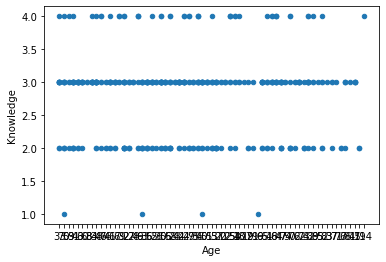

In [13]:
#This cell stores information on the age and income of people in the survey and whether they deny climate change

person = {}
how_old = list()
educated = list()
graph = {}

with open ('data/Climate Perceptions.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    
    for line in csv_reader:
        record = line["\ufeffrecord"]
        age = line["HIDAGE1"]
        postal = line["QS1"]
        concern = line["Q1r2"]
        knowledge = line["Q2"]
    
        if concern == "Extremely concerned":
            concern = 5
        elif concern == "Very concerned":
            concern = 4
        elif concern == "Don't know":
            concern = 3
        elif concern == "Not very concerned":
            concern = 2
        else:
            concern = 1
        
        if knowledge == "Extremely informed":
            knowledge = 4
        elif knowledge == "Very informed":
            knowledge = 3
        elif knowledge == "Not very informed":
            knowledge = 2
        else:
            knowledge = 1
        
        person.setdefault(record, {
            'Age': 0,
            'Concern': 0,
            'Knowledge': 0,
            'Latitude': 0,
            'Longitude': 0
        })
        
        nomi = pgeocode.Nominatim('ca')
        nomi = nomi.query_postal_code(postal)
        
        person[record]['Age'] = age
        person[record]['Concern'] = concern
        person[record]['Knowledge']  = knowledge
        person[record]['Latitude'] = nomi.latitude
        person[record]['Longitude'] = nomi.longitude
        how_old.append(age)
        educated.append(knowledge)
        
graph = pd.DataFrame({'Age': how_old, 'Knowledge': educated})
graph.plot.scatter(x = 'Age', y = 'Knowledge')